# Header
### Importing modules and reading data

In [1]:
import pandas as pd
import numpy as np

import statsmodels.formula.api as sm
import statsmodels.api as old_sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats
from sklearn import preprocessing
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Define Heaviside function as H(x)=0 for x<0, H(x)=1/2 for x=0, H(x)=1 for x>0
def heaviside(x):
    return 0.5 * (np.sign(x) + 1)

# Import data
try:
    all_seasons = pd.read_csv("Long_History.csv", encoding='utf-8', index_col=0)
    
    # Write DF to give teams numerical ID, and as lookup for team names and their ID
    teamlist = all_seasons.loc[:, "TeamH"].unique()
    data = np.array([range(len(teamlist)), teamlist]).T
    team_df = pd.DataFrame(data=data, columns=['TID', 'TName'])

except:
    print "Data import failed"

### Formatting data and writing standings

In [2]:
cleaned_df = pd.merge(team_df, all_seasons, how='inner', left_on='TName', right_on='TeamH')
cleaned_df = pd.merge(team_df, cleaned_df, how='inner', left_on='TName', right_on='TeamA', suffixes=('_A', '_H'))

columns_cl = ['Season', 'Gameday', 'TID_H', 'TID_A', 'FTHG', 'FTAG']
cleaned_df = cleaned_df.loc[:, columns_cl].sort_values(['Season', 'Gameday'])
cleaned_df.index = range(len(cleaned_df))

cleaned_df.loc[:, 'FTGD'] = cleaned_df.loc[:, 'FTHG'] - cleaned_df.loc[:, 'FTAG']

cleaned_df = cleaned_df.applymap(int)

In [205]:
def standings(df):
    def points(x):
        if x > 0:
            return 3
        elif x == 0:
            return 1
        else:
            return 0
    multi_index = pd.MultiIndex(levels=[[],[],[]],
                                labels=[[],[],[]],
                                names=[u'TID', u'Season', u'Gameday'])
    table_df = pd.DataFrame(data=None, columns=['Points', 'GD'], index=multi_index)
    
    for tid in range(len(team_df)):
        query = 'TID_H == ' + str(tid)
        temp_H = df.query(query).loc[:, ['TID_H', 'Season', 'Gameday', 'FTGD', 'FTHG']]
        temp_H.columns = ['TID_H', 'Season', 'Gameday', 'FTGD', 'FTG']
        temp_H.loc[:, 'GD'] = temp_H.loc[:, 'FTGD']
        temp_H = temp_H.drop('FTGD', axis=1)
        temp_H = temp_H.set_index(['TID_H', 'Season', 'Gameday'])

        query = 'TID_A == ' + str(tid)
        temp_A = df.query(query).loc[:, ['TID_A', 'Season', 'Gameday', 'FTGD', 'FTAG']]
        temp_A.columns = ['TID_A', 'Season', 'Gameday', 'FTGD', 'FTG']
        temp_A.loc[:, 'GD'] = -1 * temp_A.loc[:, 'FTGD']
        temp_A = temp_A.drop('FTGD', axis=1)
        temp_A = temp_A.set_index(['TID_A', 'Season', 'Gameday'])

        temp_df = pd.concat([temp_H, temp_A]).sort_index()
        temp_df.index = temp_df.index.rename(['TID', 'Season', 'Gameday'])
        temp_df.loc[:, 'Points'] = temp_df.loc[:, 'GD'].apply(points).rename('Points').to_frame()

        table_df = table_df.append(temp_df.groupby(level=['TID', 'Season'], group_keys=False).cumsum())
    
    return table_df

table_df = standings(cleaned_df)
table_df.loc[:, "Points_Plus"] = table_df.loc[:, "Points"] + 0.25/table_df.index.get_level_values(2) * table_df.loc[:, "GD"]
table_df.loc[:, "Rank"] = table_df.loc[:, "Points_Plus"].groupby(level=["Season", "Gameday"]).rank(ascending=False)

# Season end standings
# Update most recent season such that we calculate it as if 34 Games have been played.
# Normalize points to fraction of total points in season.
table_extrap_df = \
    table_df.loc[:, ["Points", "GD"]].groupby(level=['Season', 'TID']).last()/table_df.loc[:, ["Points", "GD"]].groupby(level=['Season', 'TID']).count()
table_extrap_df = table_extrap_df/[3.,1.]
    
table_extrap_by_team_df = pd.concat([
        table_extrap_df.groupby(level=['TID']).mean(), 
        table_extrap_df.groupby(level=['TID']).count().loc[:, "GD"].to_frame("Seasons")], axis = 1)

# Data Analysis
## Points at the end of the season vs goal differential

Often, the goal differential is a better indicator of playing strength than the amount of points.  
Why?  Unlike in other sports, scoring events in soccer are really rare.  At the same time, the difference between a 1-0, 2-0, or 3-0 is virtually non-existent for the final standings.  In other words, aside from adding some insurance to the lead, there is no incentive to win as high as possible.  You just have to win.  At the same time, however, a much stronger team will almost automatically score more goals per game.

Question: Is one season long enough to equilibrate?  In other words, will the goal differential explain most of the variance in points?

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Regression Summary                              
==============================================================================
Dep. Variable:                 Points   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     7237.
Date:                Mon, 27 Feb 2017   Prob (F-statistic):               0.00
Time:                        14:22:26   Log-Likelihood:                 1625.1
No. Observations:                 918   AIC:                            -3246.
Df Residuals:                     916   BIC:                            -3237.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.4575      0.001    336.032      0.000         0.455     0.460
GD             0.1821      0.002     85.070      0.000         0.178     0.186
==============================================================================
Omnibus:                       10.635   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.919
Skew:                           0.229   Prob(JB):                      0.00425
Kurtosis:                       3.276   Cond. No.                         1.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

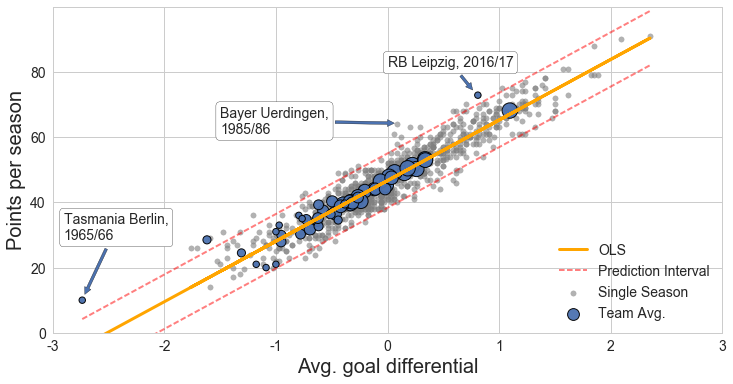

In [223]:
fig, ax = plt.subplots()

# Linear regression of points per GD; 
result = sm.ols(formula="Points ~ GD", data=table_extrap_df.loc[:, ["Points", "GD"]]).fit()
intercept_gd, slope_gd = result.params

# Formally defined
def points_per_GD(x):
    try: 
        len(x)
    except:
        x = [x]
    return result.predict(pd.DataFrame(data=x, columns=["GD"]))[0]

# Fast application
# def points_per_GD(x):
#     return intercept_gd + x * slope_gd

table_extrap_df.plot(ax=ax, kind='scatter', x='GD', y='Points', s=30, c='gray',
                     alpha=0.6, figsize=(12,6), grid=True, sharex=False, xlim=(-3,3), ylim=(0, 1./1.02), label='Single Season')

table_extrap_by_team_df.plot(ax=ax, kind='scatter', x='GD', y='Points', alpha=0.95, edgecolor='k', linewidth=1,
                             s=60*np.log(1+table_extrap_by_team_df.loc[:, "Seasons"]), label='Team Avg.')

plt.xlabel('Avg. goal differential', fontsize=20)
plt.ylabel('Points per season', fontsize=20)

# Plot 95% prediction interval
prstd, iv_l, iv_u = wls_prediction_std(result)
x = table_extrap_df.loc[:, "GD"].values
y = points_per_GD(x)
plt.plot(x, result.fittedvalues, c='orange', label='OLS', linewidth=3)
x_ix_min = np.where(x==min(x))[0][0]
x_ix_max = np.where(x==max(x))[0][0]
plt.plot([x[x_ix_min],x[x_ix_max]], [iv_u[x_ix_min], iv_u[x_ix_max]], 'r--', alpha=0.5, linewidth=2, label='Prediction Interval')
plt.plot([x[x_ix_min],x[x_ix_max]], [iv_l[x_ix_min], iv_l[x_ix_max]], 'r--', alpha=0.5, linewidth=2)

# Annotate outliers in plot
ax.annotate("RB Leipzig, 2016/17", bbox=dict(boxstyle="round", fc="w"), fontsize=14,
            xy=(0.775, 0.725), xycoords='data',
            xytext=(0.0, 0.8), textcoords='data',
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3"))

ax.annotate("Tasmania Berlin,\n1965/66", bbox=dict(boxstyle="round", fc="w"), fontsize=14,
            xy=(-2.72, 0.11), xycoords='data',
            xytext=(-2.9, 0.28), textcoords='data',
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3"))

ax.annotate("Bayer Uerdingen,\n1985/86", bbox=dict(boxstyle="round", fc="w"), fontsize=14,
            xy=(0.08, 0.63), xycoords='data',
            xytext=(-1.5, 0.6), textcoords='data',
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3"))

# Formatting
ax.set_yticks(np.arange(0, 100./102,20./102))
ax.set_yticklabels(np.arange(0, 100,20), fontsize=14)
ax.set_xticklabels(range(-3,4,1), fontsize=14)
plt.legend(loc=4, fontsize=14)

result.summary(title='Regression Summary', )

It does! $R^2 = 0.888$, so about 90% of the variance in the points can be explained by the goal differential. 
The best teams at the end of the season are those who more often outscore their opponents clearly.

## Points and goal differential in the middle of the season vs season outcome

Now that we know that the goal differential can explain a lot of the variance in the points, let's look at the standings in the middle of the season, e.g. after 10 games. How successfully can we use points and goal differential after 10 games to describe the rest of the season?

In [217]:
def comparison(gd, last_year=None, first_year=None):
    if last_year == None:
        last_year = 2016
    if first_year == None:
        first_year = 1965

    comparison_df = \
    pd.merge(
        table_df.query("Season>="+str(first_year-1)+" & Season<="+str(last_year)+" & Gameday=="+str(gd)).reset_index("Gameday", drop=True),
        table_df.query("Season>="+str(first_year-1)+" & Season<="+str(last_year)+" & Gameday==34").reset_index("Gameday", drop=True),
        left_index=True, right_index=True, how='left', suffixes=("_"+str(gd), "_34"))
    
    comparison_df.loc[:, "Points_Gained"] = comparison_df.loc[:, "Points_34"] - comparison_df.loc[:, "Points_"+str(gd)]
    comparison_df.loc[:, "Points_Gained_Plus"] = comparison_df.loc[:, "Points_Plus_34"] - comparison_df.loc[:, "Points_Plus_"+str(gd)]
    comparison_df.loc[:, "Points_Plus_"+str(gd)+"_Overshoot"] = - 3*gd*(comparison_df.loc[:, "GD_"+str(gd)]/gd).apply(points_per_GD) + comparison_df.loc[:, "Points_Plus_"+str(gd)]

    
    # Find the rank of the team in the previous season. If new team to league, set 18.
    # Take out the years 1965 and 1992 because they don't have a valid year before it.
    # 1965 first year of BL, 1991 empty DF because season was played with 20 teams instead of 18.
    comparison_df.loc[:, "Rank_m1"] = comparison_df.groupby(level='TID').shift(1).loc[:, "Rank_34"].fillna(18)
    comparison_df.loc[:, "Points_Plus_m1"] = comparison_df.groupby(level='TID').shift(1).loc[:, "Points_Plus_34"]
    comparison_df.loc[:, "GD_m1"] = comparison_df.groupby(level='TID').shift(1).loc[:, "GD_34"]
    comparison_df = comparison_df.query("Season!=1965 & Season!=1992").applymap(np.float)

    # Normalize to: GD per game, Points out of possible points, Overshoot absolute
    comparison_df = comparison_df / [gd, gd, 3*gd, 3*gd, 1, 34, 34, 102, 102, 1, 3*(34-gd), 3*(34-gd), 1, 1, 102, 34]
    return comparison_df.query("Season>="+str(first_year))

In [265]:
gd = 8
comparison_df = comparison(gd, 2015)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Points_Plus_34   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     4666.
Date:                Mon, 27 Feb 2017   Prob (F-statistic):               0.00
Time:                        15:57:16   Log-Likelihood:                 1649.7
No. Observations:                 864   AIC:                            -3293.
Df Residuals:                     861   BIC:                            -3279.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          0.0840      0.013      6.586      0.000         0.059     0.109
Points_Plus_27     0.8184      0.028     29.414      0.000         0.764     0.873
GD_27              0.0219      0.006      3.920      0.000         0.011     0.033
==============================================================================
Omnibus:                        3.638   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.162   Jarque-Bera (JB):                3.550
Skew:                          -0.120   Prob(JB):                        0.169
Kurtosis:                       2.798   Cond. No.                         28.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

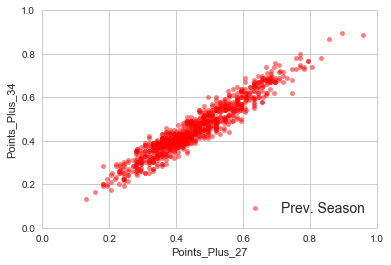

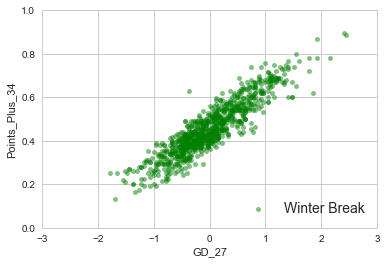

In [291]:
fig, ax = plt.subplots()
comparison_df.loc[:, ["Points_Plus_34", "Points_Plus_"+str(gd)]].plot(kind='scatter', x="Points_Plus_"+str(gd), y="Points_Plus_34",
                                                                      c='r', alpha=0.5, label="Prev. Season", ylim=(0,1), xlim=(0,1), ax=ax)
plt.legend(loc=4, fontsize=14)

comparison_df.loc[:, ["Points_Plus_34", "GD_"+str(gd)]].plot(kind='scatter', x="GD_"+str(gd), y="Points_Plus_34", 
                                                             c='g', alpha=0.5, label="Winter Break", ylim=(0,1), xlim=(-3,3))

plt.legend(loc=4, fontsize=14)
sm.ols(formula='Points_Plus_34 ~ Points_Plus_'+str(gd)+'+GD_'+str(gd), data=comparison_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Points_Gained_Plus   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     170.8
Date:                Mon, 27 Feb 2017   Prob (F-statistic):           3.95e-86
Time:                        14:44:45   Log-Likelihood:                 727.92
No. Observations:                 830   AIC:                            -1448.
Df Residuals:                     826   BIC:                            -1429.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                   0.1298      0.015      8.500      0.000         0.100     0.160
Points_Plus_m1              0.4545      0.033     13.812      0.000         0.390     0.519
Points_Plus_8               0.2605      0.026      9.832      0.000         0.208     0.312
Points_Plus_8_Overshoot    -0.0110      0.002     -4.945      0.000        -0.015    -0.007
==============================================================================
Omnibus:                        1.288   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.525   Jarque-Bera (JB):                1.323
Skew:                           0.095   Prob(JB):                        0.516
Kurtosis:                       2.952   Cond. No.                         20.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

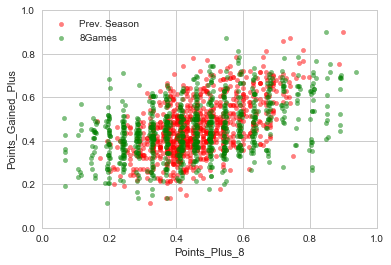

In [249]:
fig, ax = plt.subplots()
comparison_df.loc[:, ["Points_Gained_Plus", "Points_Plus_m1"]].plot(kind='scatter', x="Points_Plus_m1", y="Points_Gained_Plus",
                                                                    ax=ax, c='r', alpha=0.5, label="Prev. Season", ylim=(0,1), xlim=(0,1))
comparison_df.loc[:, ["Points_Gained_Plus", "Points_Plus_"+str(gd)]].plot(kind='scatter', x="Points_Plus_"+str(gd), y="Points_Gained_Plus", 
                                                                    ax=ax, c='g', alpha=0.5, label=str(gd)+ "Games")

sm.ols(formula='Points_Gained_Plus ~ Points_Plus_m1+Points_Plus_'+str(gd)+'+Points_Plus_'+str(gd)+'_Overshoot',
       data=comparison_df).fit().summary()

In [293]:
params = []
for gd in range(2, 34, 1):
    comparison_df = comparison(gd, 2015)
    fit = sm.ols(formula='Points_Gained_Plus ~ Points_Plus_'+str(gd)+'+GD_'+str(gd), data=comparison_df).fit()
    params.append([gd, fit.rsquared])

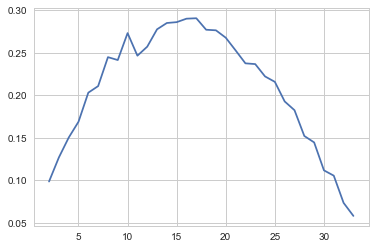

In [294]:
plt.plot(np.array(params).T[0], np.array(params).T[1])

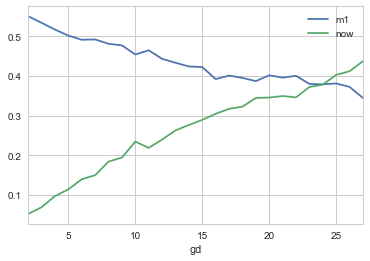

In [252]:
pd.DataFrame(data=params, columns=["gd", "m1", "now"]).set_index("gd").plot()

In [254]:
params_1 = []
for gd in range(2, 28, 2):
    comparison_df = comparison(gd, 2015)
    fit = sm.ols(formula='Points_Gained_Plus ~ Points_Plus_m1',
                 data=comparison_df).fit()
    params_1.append([gd]+ fit.params[1:2].tolist())
    
params_2 = []
for gd in range(2, 28, 2):
    comparison_df = comparison(gd, 2015)
    fit = sm.ols(formula='Points_Gained_Plus ~ Points_Plus_'+str(gd),
                 data=comparison_df).fit()
    params_2.append([gd]+ fit.params[1:2].tolist())

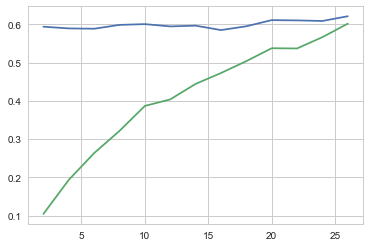

In [263]:
plt.plot(np.array(params_1).T[0], np.array(params_1).T[1])
plt.plot(np.array(params_2).T[0], np.array(params_2).T[1])